# Fruits-360 dataset

A base de dados aqui utilizada já vem padronizada e tratada, portanto seguimos com o pré-processamento a ser realizado abaixo.

## Carregamento e Vizualização

In [14]:
!pip install -r requirements.txt

In [47]:
import os
import numpy as np
import cv2
from PIL import Image
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.svm import SVC
import umap.umap_ as umap
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix
import seaborn as sns
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import pickle
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
dataset_path = "fruits_dataset/fruits-test"
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 500  # Treino em lotes
DATA_AUGMENTATION = True
NUM_CLASSES = 7

# def visualize_samples(path, num_samples=5):
#     sample_path = os.path.join(path, "Banana 1")
#     sample_images = os.listdir(sample_path)[:num_samples]
#     for img in sample_images:
#         image = Image.open(os.path.join(sample_path, img))
#         plt.imshow(image)
#         plt.axis('off')
#         plt.show()

# visualize_samples(dataset_path)

## Pré-processamento das Imagens

In [41]:
# Criar gerador de imagens para Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True
)

def load_images_and_labels(dataset_path):
    X, y = [], []
    label_encoder = LabelEncoder()

    fruit_dirs = os.listdir(dataset_path)
    label_encoder.fit(fruit_dirs)

    for fruit_dir in fruit_dirs:
        fruit_path = os.path.join(dataset_path, fruit_dir)
        img_files = os.listdir(fruit_path)

        for img_file in img_files:
            img_path = os.path.join(fruit_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar imagem: {img_path}")
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = img.astype(np.float32) / 255.0  # Normalização [0,1]
            X.append(img.flatten())  # Vetorização
            y.append(fruit_dir)

    return np.array(X), label_encoder.transform(y), label_encoder

# Carregar imagens e rótulos
X, y, label_encoder = load_images_and_labels(dataset_path)

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar Data Augmentation apenas no conjunto de treino
if DATA_AUGMENTATION:
    X_train_augmented, y_train_augmented = [], []
    X_train_reshaped = X_train.reshape(-1, 100, 100, 3)

    # Gerar novas imagens até atingir o número desejado
    aug_batches = data_gen.flow(X_train_reshaped, y_train, batch_size=BATCH_SIZE, shuffle=False)

    for i in range(len(X_train) // BATCH_SIZE):  # Gera apenas a quantidade correta de amostras
        X_batch, y_batch = next(aug_batches)
        X_train_augmented.extend(X_batch.reshape(X_batch.shape[0], -1))
        y_train_augmented.extend(y_batch)

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    # Certificar que o número de amostras bate antes de concatenar
    min_samples = min(len(X_train_augmented), len(y_train))
    X_train = np.vstack((X_train, X_train_augmented[:min_samples]))
    y_train = np.hstack((y_train, y_train_augmented[:min_samples]))

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduzir dimensionalidade com UMAP
umap_reducer = umap.UMAP(n_components=50, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train, y_train)
X_test_umap = umap_reducer.transform(X_test)

c:\Users\4seri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\4seri\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\4seri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\4seri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [42]:
### Teste para CNN

def load_images_and_labels(dataset_path):
    X, y = [], []
    label_encoder = LabelEncoder()

    # Listar as pastas (que são as classes) dentro do dataset
    fruit_dirs = os.listdir(dataset_path)
    label_encoder.fit(fruit_dirs)  # Ajuste do encoder para as classes

    for fruit_dir in fruit_dirs:
        fruit_path = os.path.join(dataset_path, fruit_dir)
        img_files = os.listdir(fruit_path)

        for img_file in img_files:
            img_path = os.path.join(fruit_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar imagem: {img_path}")
                continue
            img = cv2.resize(img, IMAGE_SIZE)  # Redimensionar a imagem
            img = img.astype(np.float32) / 255.0  # Normalizar para [0, 1]
            X.append(img)
            y.append(fruit_dir)  # Rótulo da imagem

    # Transformar os rótulos em números
    y = label_encoder.transform(y)

    return np.array(X), y, label_encoder

# Carregar as imagens e os rótulos
dataset_path = "fruits_dataset/fruits-test"
X, y, label_encoder = load_images_and_labels(dataset_path)

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar Data Augmentation se necessário
if DATA_AUGMENTATION:
    data_gen = ImageDataGenerator(
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True
    )
    
    X_train_reshaped = X_train.reshape(-1, 100, 100, 3)  # Ajustar formato para o modelo
    aug_batches = data_gen.flow(X_train_reshaped, y_train, batch_size=BATCH_SIZE, shuffle=False)
    
    X_train_augmented, y_train_augmented = [], []
    for i in range(len(X_train) // BATCH_SIZE):
        X_batch, y_batch = next(aug_batches)
        X_train_augmented.extend(X_batch)
        y_train_augmented.extend(y_batch)

    # Ajustar a variável de treino
    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    X_train = np.vstack((X_train, X_train_augmented))
    y_train = np.hstack((y_train, y_train_augmented))

# Convertendo os rótulos para one-hot encoding
y_train_cnn = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cnn = to_categorical(y_test, num_classes=NUM_CLASSES)

## Classificação de Padrões

Distribuição de Classes: Counter({5: 984, 3: 936, 0: 656, 1: 656, 4: 656, 6: 655, 2: 600})


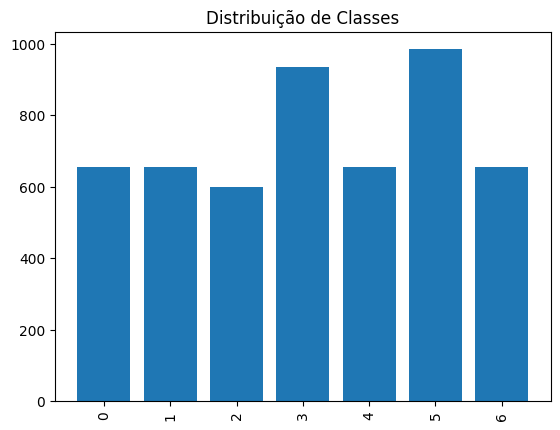

In [4]:
from collections import Counter
class_distribution = Counter(y)
print("Distribuição de Classes:", class_distribution)
sorted_classes = sorted(class_distribution.keys())
plt.bar(sorted_classes, [class_distribution[c] for c in sorted_classes])
plt.xticks(rotation=90)
plt.title("Distribuição de Classes")
plt.show()

In [ ]:
# Classificação usando SVM
param_grid = {
    'C': [0.1],
    'kernel': ['rbf'], # ['linear', 'poly', 'rbf', 'sigmoid']
    # 'degree': [2, 3, 4], # if 'poly'
    'gamma': [100] # ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_umap, y_train)
best_svm = grid_search.best_estimator_
svm_predictions = best_svm.predict(X_test_umap)

In [44]:
# Construir a CNN
cnn_model = Sequential()

# Camada convolucional + max pooling
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Achatar a saída para alimentar as camadas densas
cnn_model.add(Flatten())

# Camada densa totalmente conectada
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.7))

# Camada de saída com ativação softmax para classificação multiclasse
cnn_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compilando o modelo com as métricas desejadas
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Treinando o modelo
history = cnn_model.fit(X_train, y_train_cnn,
                        epochs=20, batch_size=32,
                        validation_data=(X_test, y_test_cnn))

Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 88s 304ms/step - AUC: 0.9285 - Precision: 0.8763 - Recall: 0.6066 - accuracy: 0.7165 - loss: 0.7514 - val_AUC: 0.9960 - val_Precision: 0.9864 - val_Recall: 0.9864 - val_accuracy: 0.9864 - val_loss: 0.0707
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 76s 300ms/step - AUC: 0.9990 - Precision: 0.9756 - Recall: 0.9615 - accuracy: 0.9661 - loss: 0.0876 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.6060e-04
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 139s 519ms/step - AUC: 0.9996 - Precision: 0.9823 - Recall: 0.9745 - accuracy: 0.9771 - loss: 0.0543 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.7134e-05
Epoch 4/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 103s 405ms/step - AUC: 0.9995 - Precision: 0.9819 - Recall: 0.9767 - accuracy: 0.9784 - loss: 0.0494 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.5220e-07
Epoch 

## Regressão de Funções e Avaliação

In [ ]:
# Avaliação do SVM
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

# Validação cruzada com SVM
svm_cv_scores = cross_val_score(best_svm, X_train_umap, y_train, cv=5)
print("SVM Cross-validation Accuracy:", svm_cv_scores.mean())

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.32      0.49       131
           1       1.00      0.23      0.37       131
           2       1.00      0.15      0.26       120
           3       1.00      0.79      0.88       188
           4       1.00      0.20      0.33       131
           5       0.27      1.00      0.42       197
           6       1.00      0.25      0.40       131

    accuracy                           0.48      1029
   macro avg       0.90      0.42      0.45      1029
weighted avg       0.86      0.48      0.48      1029

SVM Accuracy: 0.48104956268221577
SVM Cross-validation Accuracy: 0.26173752310536047


In [52]:
##cnn

from sklearn.metrics import classification_report, accuracy_score

# Fazer previsões no conjunto de teste
y_pred_cnn = cnn_model.predict(X_test)

# Converter probabilidades em classes (índices da classe prevista)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Converter os rótulos reais (one-hot encoded) de volta para índices
y_test_cnn_classes = np.argmax(y_test_cnn, axis=1)

# Gerar o relatório de classificação
print("CNN Classification Report:")
print(classification_report(y_test_cnn_classes, y_pred_cnn_classes))

# Acurácia do modelo
print("CNN Accuracy:", accuracy_score(y_test_cnn_classes, y_pred_cnn_classes))


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       131
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       188
           4       1.00      1.00      1.00       131
           5       1.00      1.00      1.00       197
           6       1.00      1.00      1.00       131

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029

CNN Accuracy: 1.0


In [ ]:
# Avaliação do SVM
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

# Validação cruzada com SVM
svm_cv_scores = cross_val_score(best_svm, X_train_umap, y_train, cv=5)
print("SVM Cross-validation Accuracy:", svm_cv_scores.mean())

In [49]:
# # Análise de variância se scores seguem uma distribuição normal e têm variâncias similares (ANOVA)
# f_stat, p_value = f_oneway(svm_cv_scores, knn_cv_scores, rf_cv_scores)
# print("ANOVA F-Statistic:", f_stat)
# print("ANOVA P-Value:", p_value)

# if p_value < 0.05:
#     print("Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.")
# else:
#     print("Não rejeitamos a hipótese nula: não há evidências de diferenças significativas entre os modelos.")

# # Análise de variância para valores se scores não seguem uma distribuição normal (Kruskal-Wallis)
# from scipy.stats import kruskal

# h_stat, p_value = kruskal(svm_cv_scores, knn_cv_scores, rf_cv_scores)
# print("Kruskal-Wallis H-Statistic:", h_stat)
# print("Kruskal-Wallis P-Value:", p_value)

# if p_value < 0.05:
#     print("Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.")
# else:
#     print("Não rejeitamos a hipótese nula: não há evidências de diferenças significativas entre os modelos.")

In [50]:
print("SVM Train Accuracy:", best_svm.score(X_train_umap, y_train))
print("SVM Test Accuracy:", accuracy_score(y_test, svm_predictions))

NameError: name 'best_svm' is not defined

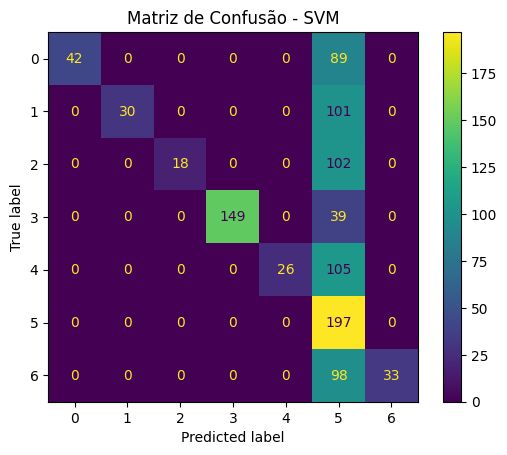

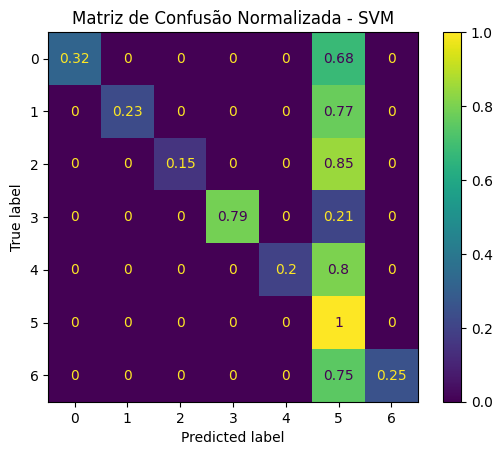

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_umap, y_test)
plt.title("Matriz de Confusão - SVM")
plt.show()

ConfusionMatrixDisplay.from_estimator(best_svm, X_test_umap, y_test, normalize='true')
plt.title("Matriz de Confusão Normalizada - SVM")
plt.show()

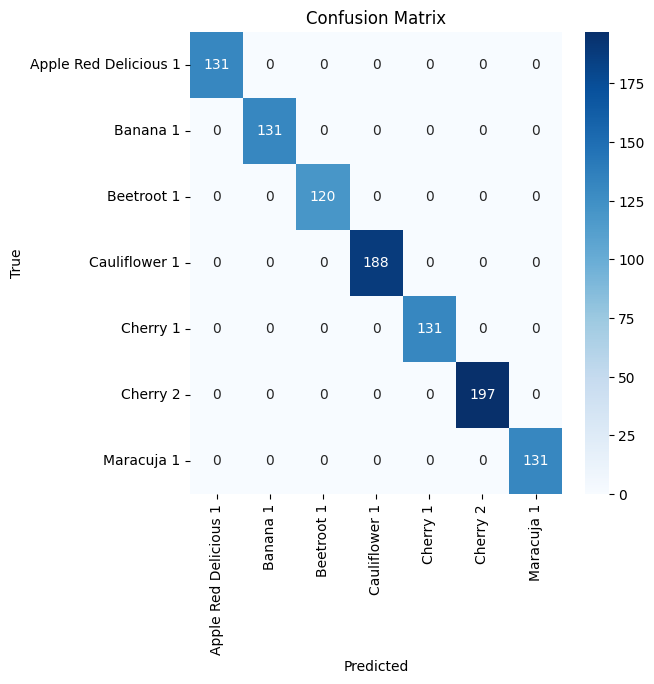

In [51]:
cm = confusion_matrix(y_test, y_pred_cnn_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Função para plotar a curva ROC para cada classe
def plot_multiclass_roc(y_test_bin, y_score, model_name):
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha de referência
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Binarizar rótulos (One-hot encoding)
n_classes = len(np.unique(y_test))  # Número de classes únicas
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Torna (901,) -> (901, n_classes)

# Probabilidades preditas pelos modelos
y_score_svm = best_svm.decision_function(X_test_umap)  # Saída do SVM

# Plotar curvas ROC para cada modelo
plot_multiclass_roc(y_test_bin, y_score_svm, "SVM")

In [ ]:
def plot_error_2d(errors, title):
    plt.scatter(errors[:, 0], errors[:, 1], color='red', label='Erros')
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.show()

# Encontrar amostras mal classificadas corretamente
errors_svm = X_test_umap[np.where(y_test != svm_predictions)]

# Plotar os erros para cada modelo
plot_error_2d(errors_svm, "Distribuição de Erros - SVM")

In [ ]:
def plot_learning_curve(train_sizes, train_mean, test_mean, title):
    plt.plot(train_sizes, train_mean, label='Treinamento', color='blue')
    plt.plot(train_sizes, test_mean, label='Validação', color='orange')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(best_svm, X_train_umap, y_train, cv=5)
train_mean_svm = train_scores_svm.mean(axis=1)
test_mean_svm = test_scores_svm.mean(axis=1)
plot_learning_curve(train_sizes_svm, train_mean_svm, test_mean_svm, "Curva de Aprendizado - SVM")

In [ ]:
def plot_validation_curve(param_range, train_mean, test_mean, title):
    plt.plot(param_range, train_mean, label='Treinamento', color='blue')
    plt.plot(param_range, test_mean, label='Validação', color='orange')
    plt.xlabel('Parâmetro C')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

param_range = [0.1, 1, 10, 100]

train_scores_vc_svm, test_scores_vc_svm = validation_curve(SVC(), X_train_umap, y_train, param_name="C", param_range=param_range, cv=5)
train_mean_vc_svm = train_scores_vc_svm.mean(axis=1)
test_mean_vc_svm = test_scores_vc_svm.mean(axis=1)
plot_validation_curve(param_range, train_mean_vc_svm, test_mean_vc_svm, "Curva de Validação - SVM")

In [ ]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão - Heatmap")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

cm_svm = confusion_matrix(y_test, svm_predictions)

plot_confusion_matrix(cm_svm)

## Salvando os Resultados

In [ ]:
# # Salva características para uso posterior
# with open("features.pkl", "wb") as f:
#     pickle.dump((features_batch, labels_batch), f)

# MobileNet
O MobileNet é uma rede neural leve e eficiente, ideal para classificação de imagens em dispositivos com recursos limitados. Ele usa convoluções separáveis para reduzir custos computacionais e memória, mantendo boa precisão. Pré-treinado no ImageNet, é fácil adaptá-lo via transfer learning para tarefas específicas, como classificação de frutas. Comparado ao SVM, ele aprende características automaticamente e escala melhor para grandes volumes de dados. É uma escolha robusta para aplicações em tempo real e comparações com modelos clássicos.

## Pré-processamento das imagens

In [ ]:
dataset_path = "fruits_dataset/fruits-test"
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 500  # Treino em lotes
DATA_AUGMENTATION = True

# Criar gerador de imagens para Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True
)

def load_images_and_labels(dataset_path):
    X, y = [], []
    label_encoder = LabelEncoder()

    fruit_dirs = os.listdir(dataset_path)
    label_encoder.fit(fruit_dirs)

    for fruit_dir in fruit_dirs:
        fruit_path = os.path.join(dataset_path, fruit_dir)
        img_files = os.listdir(fruit_path)

        for img_file in img_files:
            img_path = os.path.join(fruit_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar imagem: {img_path}")
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = img.astype(np.float32) / 255.0  # Normalização [0,1]
            X.append(img)  # Não achatar a imagem
            y.append(fruit_dir)

    return np.array(X), label_encoder.transform(y), label_encoder

# Carregar imagens e rótulos
X, y, label_encoder = load_images_and_labels(dataset_path)

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar Data Augmentation apenas no conjunto de treino
if DATA_AUGMENTATION:
    X_train_augmented, y_train_augmented = [], []

    # Gerar novas imagens até atingir o número desejado
    aug_batches = data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False)

    for i in range(len(X_train) // BATCH_SIZE):  # Gera apenas a quantidade correta de amostras
        X_batch, y_batch = next(aug_batches)
        X_train_augmented.extend(X_batch)
        y_train_augmented.extend(y_batch)

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    # Certificar que o número de amostras bate antes de concatenar
    min_samples = min(len(X_train_augmented), len(y_train))
    X_train = np.vstack((X_train, X_train_augmented[:min_samples]))
    y_train = np.hstack((y_train, y_train_augmented[:min_samples]))

# Normalização (não necessário para MobileNet, pois ele já faz isso internamente)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Reduzir dimensionalidade com UMAP (não necessário para MobileNet)
# umap_reducer = umap.UMAP(n_components=50, random_state=42)
# X_train_umap = umap_reducer.fit_transform(X_train, y_train)
# X_test_umap = umap_reducer.transform(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'fruits_dataset/fruits-test'

## Classificação usando MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report

# Carregar o modelo MobileNet pré-treinado (sem a camada fully connected no topo)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Adicionar camadas personalizadas no topo do modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas do MobileNet para evitar que sejam treinadas
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Fazer previsões
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Avaliação do MobileNet
print("MobileNet Classification Report:")
print(classification_report(y_test, y_pred_classes))
print("MobileNet Accuracy:", accuracy_score(y_test, y_pred_classes))

# Validação cruzada com MobileNet (não é comum para redes neurais, mas pode ser feito)
# Aqui, você pode usar KFold manualmente ou outras técnicas de validação cruzada.

## Comparação entre SVM e MobileNet

In [ ]:
print("Comparação entre SVM e MobileNet:")
print(f"SVM Accuracy: {accuracy_score(y_test, svm_predictions)}")
print(f"MobileNet Accuracy: {accuracy_score(y_test, y_pred_classes)}")

## Acurácia do treino e teste

In [ ]:
# Acurácia do treino
train_predictions = np.argmax(model.predict(X_train), axis=1)
train_accuracy = accuracy_score(y_train, train_predictions)
print("MobileNet Train Accuracy:", train_accuracy)

# Acurácia do teste
test_predictions = np.argmax(model.predict(X_test), axis=1)
test_accuracy = accuracy_score(y_test, test_predictions)
print("MobileNet Test Accuracy:", test_accuracy)

## Matriz de confusão

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusão não normalizada
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.title("Matriz de Confusão - MobileNet")
plt.show()

# Matriz de confusão normalizada
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions, normalize='true')
plt.title("Matriz de Confusão Normalizada - MobileNet")
plt.show()

## Curva ROC multiclasse

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Função para plotar a curva ROC para cada classe
def plot_multiclass_roc(y_test_bin, y_score, model_name):
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha de referência
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Binarizar rótulos (One-hot encoding)
n_classes = len(np.unique(y_test))  # Número de classes únicas
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Torna (901,) -> (901, n_classes)

# Probabilidades preditas pelo MobileNet
y_score_mobilenet = model.predict(X_test)  # Saída do MobileNet (probabilidades)

# Plotar curvas ROC para o MobileNet
plot_multiclass_roc(y_test_bin, y_score_mobilenet, "MobileNet")

## Distribuição de erros

In [ ]:
from sklearn.decomposition import PCA

# Reduzir dimensionalidade com PCA para visualização
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test.reshape(X_test.shape[0], -1))

# Encontrar amostras mal classificadas
errors_mobilenet = X_test_pca[np.where(y_test != test_predictions)]

# Função para plotar erros
def plot_error_2d(errors, title):
    plt.scatter(errors[:, 0], errors[:, 1], color='red', label='Erros')
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.show()

# Plotar os erros para o MobileNet
plot_error_2d(errors_mobilenet, "Distribuição de Erros - MobileNet")

## Curva de Aprendizado e Validação

In [ ]:
from sklearn.model_selection import learning_curve

# Função para plotar a curva de aprendizado
def plot_learning_curve(train_sizes, train_mean, test_mean, title):
    plt.plot(train_sizes, train_mean, label='Treinamento', color='blue')
    plt.plot(train_sizes, test_mean, label='Validação', color='orange')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

# Calcular a curva de aprendizado
train_sizes_mobilenet, train_scores_mobilenet, test_scores_mobilenet = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean_mobilenet = train_scores_mobilenet.mean(axis=1)
test_mean_mobilenet = test_scores_mobilenet.mean(axis=1)
plot_learning_curve(train_sizes_mobilenet, train_mean_mobilenet, test_mean_mobilenet, "Curva de Aprendizado - MobileNet")

## Matriz de Confusão com Heatmap

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar a matriz de confusão com heatmap
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão - Heatmap")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# Matriz de confusão para o MobileNet
cm_mobilenet = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(cm_mobilenet)

## Salvar Características

In [ ]:
import pickle

# Extrair características usando o MobileNet
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)  # Extrai a penúltima camada
features = feature_extractor.predict(X_train)

# Salvar características e rótulos
with open("features_mobilenet.pkl", "wb") as f:
    pickle.dump((features, y_train), f)